In [1]:
import numpy as np
import pickle
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/MyDrive/'
X_train = np.load(base_path + 'X_train.npy')
y_train = np.load(base_path + 'y_train.npy')
X_val   = np.load(base_path + 'X_val.npy')
y_val   = np.load(base_path + 'y_val.npy')

In [7]:
print("Shapes:", X_train.shape, y_train.shape)
print("Shapes:", X_val.shape, y_val.shape)

Shapes: (300, 16, 112, 112, 3) (300,)
Shapes: (80, 16, 112, 112, 3) (80,)


In [8]:
from collections import Counter
counter = Counter(y_train)
counter1 = Counter(y_val)
print(counter)
print(counter1)

Counter({np.int64(1): 151, np.int64(0): 149})
Counter({np.int64(1): 42, np.int64(0): 38})


#model_1

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np

In [10]:
def create_cnn_lstm_model(sequence_length=16, frame_height=112, frame_width=112, channels=3, num_classes=1):
    """
    Create a CNN-LSTM model for accident detection using pretrained DenseNet201
    """

    input_layer = Input(shape=(sequence_length, frame_height, frame_width, channels))


    cnn_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(frame_height, frame_width, channels)
    )


    for layer in cnn_model.layers[:-30]:
        layer.trainable = False
    for layer in cnn_model.layers[-30:]:
        layer.trainable = True


    cnn_features = TimeDistributed(cnn_model)(input_layer)


    cnn_features = BatchNormalization()(cnn_features)


    lstm1 = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(cnn_features)
    lstm1 = BatchNormalization()(lstm1)

    lstm2 = LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(lstm1)
    lstm2 = BatchNormalization()(lstm2)


    lstm3 = LSTM(32, dropout=0.1, recurrent_dropout=0.1)(lstm2)


    dense1 = Dense(64, activation='relu')(lstm3)
    dense1 = Dropout(0.3)(dense1)
    dense1 = BatchNormalization()(dense1)


    if num_classes == 1:
        output_layer = Dense(1, activation='sigmoid')(dense1)
    else:
        output_layer = Dense(num_classes, activation='softmax')(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


model = create_cnn_lstm_model(sequence_length=16, frame_height=112, frame_width=112, channels=3, num_classes=1)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 1920)       │    18,321,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 1920)       │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16, 128)        │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,443,777 (74.17 MB)

 Trainable params: 2,222,977 (8.48 MB)

 Non-trainable params: 17,220,800 (65.69 MB)

In [16]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),

    ModelCheckpoint(
        filepath='best_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]


In [17]:
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5042 - loss: 0.8662
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.5049 - loss: 0.8657 - val_accuracy: 0.4875 - val_loss: 0.6973 - learning_rate: 1.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.4480 - loss: 0.8667
Epoch 2: val_accuracy improved from 0.48750 to 0.53750, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 942ms/step - accuracy: 0.4491 - loss: 0.8661 - val_accuracy: 0.5375 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.5557 - loss: 0.7591
Epoch 3: val_accuracy did not improve from 0.53750
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 917ms/step - accuracy: 0.5554 - loss: 0.7597 - val_accuracy: 0.4750 - val_loss: 0.6894 - learning_rate: 1.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.6330 - loss: 0.6679
Epoch 4: val_accuracy improved from 0.53750 to 0.56250, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 933ms/step - accuracy: 0.6325 - loss: 0.6692 - val_accuracy: 0.5625 - val_loss: 0.6548 - learning_rate: 1.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.6164 - loss: 0.6735
Epoch 5: val_accuracy improved from 0.56250 to 0.61250, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 941ms/step - accuracy: 0.6160 - loss: 0.6739 - val_accuracy: 0.6125 - val_loss: 0.6424 - learning_rate: 1.0000e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.6207 - loss: 0.7208
Epoch 6: val_accuracy did not improve from 0.61250
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 906ms/step - accuracy: 0.6211 - loss: 0.7204 - val_accuracy: 0.6000 - val_loss: 0.6403 - learning_rate: 1.0000e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.6634 - loss: 0.6451
Epoch 7: val_accuracy did not improve from 0.61250
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 896ms/step - accuracy: 0.6627 - loss: 0.6460 - val_accuracy: 0.6125 - val_loss: 0.6203 - learning_rate: 1.0000e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.6164 - loss: 0.7526
Epoch 8: val_accuracy did not improve from 0.61250
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 890ms/step - accuracy: 0.6168 - loss: 0.7511 - val_accuracy: 0.6000 - val_loss: 0.6226 - learning_rate: 1.0000e-04
Epoch

38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 923ms/step - accuracy: 0.6557 - loss: 0.6738 - val_accuracy: 0.6250 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6005 - loss: 0.7860
Epoch 11: val_accuracy did not improve from 0.62500
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.6015 - loss: 0.7839 - val_accuracy: 0.6250 - val_loss: 0.6176 - learning_rate: 1.0000e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.6799 - loss: 0.6432
Epoch 12: val_accuracy did not improve from 0.62500
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 894ms/step - accuracy: 0.6797 - loss: 0.6430 - val_accuracy: 0.6250 - val_loss: 0.6537 - learning_rate: 1.0000e-04
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6989 - loss: 0.5739
Epoch 13: val_accuracy improved from 0.62500 to 0.63750, saving model to best_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 915ms/step - accuracy: 0.6985 - loss: 0.5747 - val_accuracy: 0.6375 - val_loss: 0.6739 - learning_rate: 1.0000e-04
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.6894 - loss: 0.5969
Epoch 14: val_accuracy did not improve from 0.63750
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 898ms/step - accuracy: 0.6892 - loss: 0.5978 - val_accuracy: 0.6250 - val_loss: 0.6936 - learning_rate: 1.0000e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.6741 - loss: 0.5832
Epoch 15: val_accuracy did not improve from 0.63750
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 890ms/step - accuracy: 0.6750 - loss: 0.5832 - val_accuracy: 0.6125 - val_loss: 0.7066 - learning_rate: 1.0000e-04
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6852 - loss: 0.6131
Epoch 16: val_accuracy did not improve from 0.63750
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 885ms/step - accuracy: 0.6853 - loss: 0.6133 - val_accuracy: 0.5875 - val_loss: 0.7627 - learning_rate: 1.0000e-04

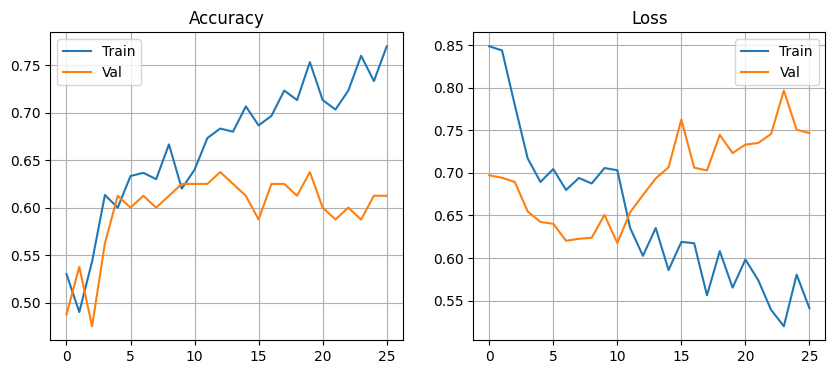

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_val, y_pred, digits=3))


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 964ms/step
              precision    recall  f1-score   support

           0      0.583     0.737     0.651        38
           1      0.688     0.524     0.595        42

    accuracy                          0.625        80
   macro avg      0.635     0.630     0.623        80
weighted avg      0.638     0.625     0.621        80



#model_2

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras import Sequential

In [5]:
video_augment = Sequential([
    TimeDistributed(RandomFlip("horizontal")),
    TimeDistributed(RandomRotation(0.1)),
    TimeDistributed(RandomContrast(0.2)),
])

In [6]:
def create_regularized_cnn_lstm(sequence_length=16, frame_height=112, frame_width=112, channels=3, num_classes=1):
    input_layer = Input(shape=(sequence_length, frame_height, frame_width, channels))

    # CNN Backbone
    cnn_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg',
                            input_shape=(frame_height, frame_width, channels))
    for layer in cnn_model.layers[:-15]:
        layer.trainable = False
    for layer in cnn_model.layers[-15:]:
        layer.trainable = True

    cnn_features = TimeDistributed(cnn_model)(input_layer)

    # LSTM layers with regularization
    lstm1 = LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3,
                 kernel_regularizer=regularizers.l2(1e-4))(cnn_features)
    lstm2 = LSTM(64, dropout=0.3, recurrent_dropout=0.3,
                 kernel_regularizer=regularizers.l2(1e-4))(lstm1)

    # Dense block
    dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(lstm2)
    dense = Dropout(0.5)(dense)
    dense = BatchNormalization()(dense)

    output = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=input_layer, outputs=output)
    return model

In [7]:
model = create_regularized_cnn_lstm()
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1920)       │    18,321,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16, 128)        │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,424,961 (74.10 MB)

 Trainable params: 1,663,937 (6.35 MB)

 Non-trainable params: 17,761,024 (67.75 MB)

In [9]:
def video_generator(X, y, batch_size):
    while True:
        idx = np.random.choice(len(X), batch_size)
        batch_X = video_augment(X[idx])
        batch_y = y[idx]
        yield batch_X, batch_y

In [10]:
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint(
        filepath='best_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]

In [11]:
batch_size = 8
epochs = 50

history = model.fit(
    video_generator(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.4641 - loss: 0.9791
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to best_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 521s 5s/step - accuracy: 0.4655 - loss: 0.9777 - val_accuracy: 0.5375 - val_loss: 0.7931 - learning_rate: 1.0000e-04
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.5181 - loss: 0.8957
Epoch 2: val_accuracy improved from 0.53750 to 0.58750, saving model to best_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 833ms/step - accuracy: 0.5178 - loss: 0.8963 - val_accuracy: 0.5875 - val_loss: 0.7788 - learning_rate: 1.0000e-04
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.5571 - loss: 0.8265
Epoch 3: val_accuracy improved from 0.58750 to 0.60000, saving model to best_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 828ms/step - accuracy: 0.5567 - loss: 0.8271 - val_accuracy: 0.6000 - val_loss: 0.7668 - learning_rate: 1.0000e-04
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.5139 - loss: 0.8148
Epoch 4: val_accuracy improved from 0.60000 to 0.61250, saving model to best_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 825ms/step - accuracy: 0.5148 - loss: 0.8149 - val_accuracy: 0.6125 - val_loss: 0.7565 - learning_rate: 1.0000e-04
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.6147 - loss: 0.7847
Epoch 5: val_accuracy improved from 0.61250 to 0.67500, saving model to best_model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 880ms/step - accuracy: 0.6150 - loss: 0.7849 - val_accuracy: 0.6750 - val_loss: 0.7350 - learning_rate: 1.0000e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.5826 - loss: 0.7926
Epoch 6: val_accuracy did not improve from 0.67500
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 815ms/step - accuracy: 0.5825 - loss: 0.7922 - val_accuracy: 0.6000 - val_loss: 0.7329 - learning_rate: 1.0000e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.6613 - loss: 0.7685
Epoch 7: val_accuracy did not improve from 0.67500
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 785ms/step - accuracy: 0.6606 - loss: 0.7683 - val_accuracy: 0.5625 - val_loss: 0.7613 - learning_rate: 1.0000e-04
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.5784 - loss: 0.8026
Epoch 8: val_accuracy did not improve from 0.67500
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 785ms/step - accuracy: 0.5783 - loss: 0.8026 - val_accuracy: 0.5375 - val_loss: 0.7776 - learning_rate: 1.0000e-04
Epoch

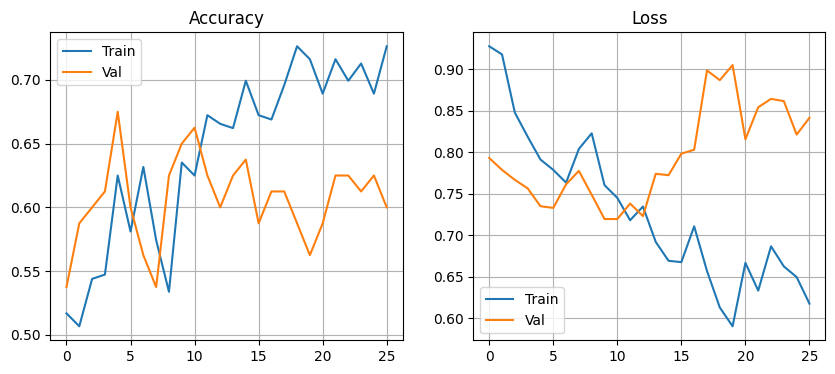

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_val, y_pred, digits=3))

3/3 ━━━━━━━━━━━━━━━━━━━━ 239s 58s/step
              precision    recall  f1-score   support

           0      0.641     0.658     0.649        38
           1      0.683     0.667     0.675        42

    accuracy                          0.662        80
   macro avg      0.662     0.662     0.662        80
weighted avg      0.663     0.662     0.663        80

